In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import sys
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import os
import json

In [3]:
# some function to process in this example the function looks to match hits and waveforms 

def process_event(event):
    #this function acts on one readout window (or event) 
    hit_times  = event["hit_pmt_times"]
    hit_cards  = event["hit_mpmt_card_ids"]
    hit_chan   = event["hit_pmt_channel_ids"]

    wf_start   = event["pmt_waveform_times"]
    wf_wave    = event["pmt_waveforms"]
    wf_end     = wf_start + 8.0 * ak.num(wf_wave)
    wf_card    = event["pmt_waveform_mpmt_card_ids"]
    wf_chan    = event["pmt_waveform_pmt_channel_ids"]

    # ----------------------------------------
    # Vectorized matching
    # ----------------------------------------

    # Broadcast hits vs waveforms
    card_match = hit_cards == wf_card[:, None]
    chan_match = hit_chan == wf_chan[:, None]
    time_match = (hit_times > wf_start[:, None]) & (hit_times < wf_end[:, None])

    match_matrix = card_match & chan_match & time_match  # (wf, hits)
    ##2d array of true and false for matches of each hit to each waveform

    # ----------------------------------------
    # For each hit → find waveform
    # ----------------------------------------
    hit_nmatch = ak.sum(match_matrix, axis=0)
    hit_match_index = ak.argmax(match_matrix, axis=0)     # first True or 0

    # Hits with no waveform
    hits_no_wf = hit_times[hit_nmatch == 0]
    
    # ----------------------------------------
    # For each waveform → find hit
    # ----------------------------------------
    wf_nmatch = ak.sum(match_matrix, axis=1)
    wf_match_index = ak.argmax(match_matrix, axis=1)

    # Waveforms with no hits
    wf_no_hits = wf_start[wf_nmatch == 0]
    # return the times of the hits with no matched waveforms and waveforms with no matched hits
    return hits_no_wf, wf_no_hits
    

In [5]:
runNumber = 1703
file_path = "/eos/experiment/wcte/data/2025_commissioning/offline_data_vme_match/WCTE_offline_R"+str(runNumber)+"S0_VME_matched.root"

batch_size = 1000

#some output arrays for some quanity we want to extract or calculate from the data 
total_hits_no_wf = []
total_wf_no_hits = []

total_window_counter =0 
with uproot.open(file_path) as root_file:
    tree = root_file["WCTEReadoutWindows"]
    total_entries = tree.num_entries
    all_branches = tree.keys()
    
    for start in range(0, total_entries, batch_size):
        if total_window_counter > 10_000:
            break
        stop = min(start + batch_size, total_entries)
        print(f"Loading entries {start} → {stop}")
        
        #open the events in a batch
        events = tree.arrays(all_branches,library="ak", entry_start=start, entry_stop=stop)

        # Process the batch ideally in the most vectorised way possible for speed
        for iev, event in enumerate(events):
            total_window_counter+=1
            if iev%100==0:
                print("On iev",iev)
            (hits_no, wf_no) = process_event(event)  # use optimized function
            total_hits_no_wf.extend(hits_no)
            total_wf_no_hits.extend(wf_no)

Loading entries 0 → 1000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 1000 → 2000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 2000 → 3000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 3000 → 4000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 4000 → 5000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 5000 → 6000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 6000 → 7000
On iev 0
On iev 100
On iev 200
On iev 300
On iev 400
On iev 500
On iev 600
On iev 700
On iev 800
On iev 900
Loading entries 7000 → 8000
On iev 0
On iev 100
On 

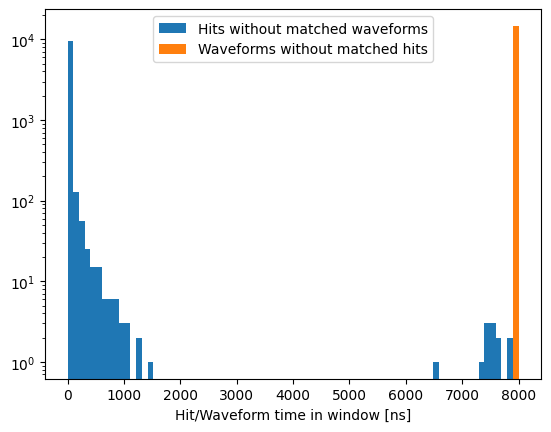

In [6]:
## now you can work with the information extracted from data, 
# you can save them to file to reload without needing to go back to the original file
plt.hist(total_hits_no_wf,bins = np.linspace(0,8000,80), label = "Hits without matched waveforms")
plt.hist(total_wf_no_hits,bins = np.linspace(0,8000,80), label = "Waveforms without matched hits")
plt.xlabel("Hit/Waveform time in window [ns]")
plt.yscale("log")
plt.legend()